In [ ]:
from google.colab import drive
import os
from PIL import Image

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# Change this path to the exact folder where your images are located
INPUT_FOLDER = '/content/drive/MyDrive/open defect'
OUTPUT_FOLDER_NAME = 'cleaned_dataset3'

def process_images(input_path):
    # Setup full output path
    output_path = os.path.join(input_path, OUTPUT_FOLDER_NAME)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        print(f"Created folder: {output_path}")

    # Exclusions
    skip_suffixes = ("_90.jpeg", "_180.jpeg", "_270.jpeg")

    files = [f for f in os.listdir(input_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    processed_count = 0

    print("Processing...")
    for filename in files:
        # Check if the file should be ignored based on suffix
        if any(filename.lower().endswith(suffix) for suffix in skip_suffixes):
            continue

        img_path = os.path.join(input_path, filename)

        try:
            with Image.open(img_path) as img:
                width, height = img.size

                # Gemini logo is in the bottom right corner.
                # Cropping 70 pixels from the bottom ensures the logo and
                # its slight gradient shadow are completely removed.
                # Box format: (left, top, right, bottom)
                crop_box = (0, 0, width, height - 80)
                cropped_img = img.crop(crop_box)

                # Save to the new subfolder
                cropped_img.save(os.path.join(output_path, filename))
                processed_count += 1
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

    print(f"\n--- Process Complete ---")
    print(f"Total images processed and saved: {processed_count}")
    print(f"Location: {output_path}")

# Run the function
process_images(INPUT_FOLDER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created folder: /content/drive/MyDrive/open defect/cleaned_dataset3
Processing...

--- Process Complete ---
Total images processed and saved: 48
Location: /content/drive/MyDrive/open defect/cleaned_dataset3


In [ ]:
from google.colab import drive
import os
from PIL import Image
drive.mount('/content/drive', force_remount=True)


# --- CONFIGURATION ---
# Use the 'cleaned_dataset' path generated from the previous script
SOURCE_FOLDER = '/content/drive/MyDrive/generate_image_ler'

def rotate_dataset(folder_path):
    # Supported rotation angles
    angles = [90, 180, 270]

    # Get only the base images (ignore any already rotated files if you run this twice)
    files = [f for f in os.listdir(folder_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))
             and not any(suffix in f for suffix in ["_90", "_180", "_270"])]

    print(f"Found {len(files)} base images. Generating rotations...")

    count = 0
    for filename in files:
        img_path = os.path.join(folder_path, filename)
        name, ext = os.path.splitext(filename)

        try:
            with Image.open(img_path) as img:
                for angle in angles:
                    # Rotate and save
                    # Using expand=True ensures the whole image is kept if dimensions change
                    # though for square/cropped SEM data, this is straightforward.
                    rotated_img = img.rotate(angle, expand=True)

                    new_filename = f"{name}_{angle}{ext}"
                    rotated_img.save(os.path.join(folder_path, new_filename))
                    count += 1
        except Exception as e:
            print(f"Error rotating {filename}: {e}")

    print(f"\nSuccess! Generated {count} rotated images.")
    print(f"Total images now in folder: {len(os.listdir(folder_path))}")

# Execute
rotate_dataset(SOURCE_FOLDER)

Mounted at /content/drive
Found 50 base images. Generating rotations...

Success! Generated 150 rotated images.
Total images now in folder: 200


In [ ]:
import os
import shutil
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Paths (Update these to your specific folder names)
source_dir = '/content/drive/MyDrive/Anomaly_train'
dest_dir = '/content/drive/MyDrive/dataset/normal'

# Create destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
    print(f"Created directory: {dest_dir}")

# 3. Parameters
prefix = "test_normal_"
extension = ".jpg"
limit = 1200
counter = 0

# 4. Execution Logic
files = os.listdir(source_dir)
files.sort() # Sorting ensures consistency

print("Starting copy process...")

for filename in files:
    # Check if filename starts with prefix and ends with extension
    if filename.startswith(prefix) and filename.lower().endswith(extension):
        source_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(dest_dir, filename)

        # Copy the file
        shutil.copy2(source_path, dest_path)
        counter += 1

        # Print progress every 100 files
        if counter % 100 == 0:
            print(f"Copied {counter} files...")

    # Stop once the limit is reached
    if counter >= limit:
        break

print(f"--- Process Complete ---")
print(f"Total files copied: {counter}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting copy process...
Copied 100 files...
Copied 200 files...


In [ ]:
import os
import shutil
import time
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Paths
source_dir = '/content/drive/MyDrive/Anomaly_train'
dest_dir = '/content/drive/MyDrive/dataset/defect/cmp_crack/cmp'
prefix = "test_normal_"
limit = 1200

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# 3. Identify what is already finished
# We get a set of filenames already in the destination to avoid duplicates
existing_files = set(os.listdir(dest_dir))
current_count = len([f for f in existing_files if f.startswith(prefix)])

print(f"Already have {current_count} files in destination.")

if current_count >= limit:
    print("Goal already reached!")
else:
    # 4. Resume Copying
    remaining_needed = limit - current_count
    copied_this_session = 0

    print(f"Attempting to copy {remaining_needed} more files...")

    # Using scandir for better performance on large directories
    with os.scandir(source_dir) as entries:
        for entry in entries:
            if copied_this_session >= remaining_needed:
                break

            # Match naming convention and ensure it's not already copied
            if (entry.is_file() and
                entry.name.startswith(prefix) and
                entry.name.lower().endswith('.jpg') and
                entry.name not in existing_files):

                try:
                    shutil.copy2(entry.path, os.path.join(dest_dir, entry.name))
                    copied_this_session += 1

                    if copied_this_session % 50 == 0:
                        print(f"Progress: {current_count + copied_this_session}/{limit}")
                        time.sleep(0.1) # Brief pause to satisfy Drive API

                except Exception as e:
                    print(f"Skipping {entry.name} due to error: {e}")
                    continue

    print(f"Session finished. Total files now in destination: {current_count + copied_this_session}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Already have 261 files in destination.
Attempting to copy 939 more files...
Progress: 311/1200
Progress: 361/1200
Progress: 411/1200
Progress: 461/1200
Progress: 511/1200
Progress: 561/1200
Progress: 611/1200
Progress: 661/1200
Progress: 711/1200
Progress: 761/1200
Progress: 811/1200
Progress: 861/1200
Progress: 911/1200
Progress: 961/1200
Progress: 1011/1200
Progress: 1061/1200
Progress: 1111/1200
Progress: 1161/1200
Session finished. Total files now in destination: 1200


In [ ]:
import os
import time
from PIL import Image
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Paths
source_dir = '/content/drive/MyDrive/open defect/cleaned_dataset3'
dest_dir = '/content/drive/MyDrive/dataset/defect/open_bridge/open'
target_size = (224, 224)

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# 3. Get existing files to avoid duplicates
existing_files = set(os.listdir(dest_dir))

# 4. Comprehensive Processing
processed_count = 0
skipped_count = 0
error_count = 0

# Allowed formats
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

print(f"Scanning {source_dir}...")

# Use os.listdir to force a full refresh of the file list
files = os.listdir(source_dir)
print(f"Total items found in source folder: {len(files)}")

for filename in files:
    # 1. Check extension (Case-Insensitive)
    if filename.lower().endswith(valid_extensions):

        # 2. Skip if already done
        if filename in existing_files:
            skipped_count += 1
            continue

        try:
            full_path = os.path.join(source_dir, filename)

            with Image.open(full_path) as img:
                # 3. Robust conversion (handles Grayscale, Palette, and Alpha channels)
                img_rgb = img.convert('RGB')
                img_resized = img_rgb.resize(target_size, Image.Resampling.LANCZOS)

                # Save as JPEG in destination
                save_path = os.path.join(dest_dir, filename)
                img_resized.save(save_path, "JPEG", quality=95)

            processed_count += 1
            if processed_count % 10 == 0:
                print(f"Done: {processed_count} images...")

        except Exception as e:
            print(f"!! Error with {filename}: {e}")
            error_count += 1
    else:
        # This tracks files that aren't images (like .DS_Store or folders)
        pass

print("\n--- Final Report ---")
print(f"Successfully Processed: {processed_count}")
print(f"Skipped (Already Exist): {skipped_count}")
print(f"Errors encountered: {error_count}")
print(f"Total in Destination: {len(os.listdir(dest_dir))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Scanning /content/drive/MyDrive/open defect/cleaned_dataset3...
Total items found in source folder: 192
Done: 10 images...
Done: 20 images...
Done: 30 images...
Done: 40 images...
Done: 50 images...
Done: 60 images...
Done: 70 images...
Done: 80 images...
Done: 90 images...
Done: 100 images...
Done: 110 images...
Done: 120 images...
Done: 130 images...
Done: 140 images...
Done: 150 images...
Done: 160 images...
Done: 170 images...
Done: 180 images...
Done: 190 images...

--- Final Report ---
Successfully Processed: 192
Skipped (Already Exist): 0
Errors encountered: 0
Total in Destination: 192


In [ ]:
import os
from PIL import Image
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Paths
source_dir = '/content/drive/MyDrive/Anomaly_train'
dest_dir = '/content/drive/MyDrive/dataset/normal'
target_size = (224, 224)
limit = 1200

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# 3. Identify current progress to support resuming
existing_files = os.listdir(dest_dir)
# Assuming files are named test_normal_xxxxx.jpg, we find the highest index
existing_indices = [int(f.split('_')[-1].split('.')[0]) for f in existing_files if f.startswith('test_normal_')]
start_index = max(existing_indices) + 1 if existing_indices else 1
current_total = len(existing_indices)

print(f"Destination already has {current_total} images. Starting from index {start_index}...")

# 4. Processing Logic
processed_this_session = 0
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

if current_total >= limit:
    print("Goal of 1200 images already met!")
else:
    # Get source files and sort to ensure "1st 1200" is consistent
    source_files = sorted(os.listdir(source_dir))

    for filename in source_files:
        # Stop if we hit the limit (overall)
        if (current_total + processed_this_session) >= limit:
            break

        if filename.lower().endswith(valid_extensions):
            # To avoid re-processing images we might have already moved/renamed,
            # we check if the image is already in the destination by original name?
            # Actually, since we rename them, we rely on the loop to find 'new' files.

            try:
                full_path = os.path.join(source_dir, filename)

                # Format the new name: test_normal_00001.jpg
                new_name = f"test_normal_{str(start_index + processed_this_session).zfill(5)}.jpg"
                dest_path = os.path.join(dest_dir, new_name)

                with Image.open(full_path) as img:
                    img_rgb = img.convert('RGB')
                    img_resized = img_rgb.resize(target_size, Image.Resampling.LANCZOS)
                    img_resized.save(dest_path, "JPEG", quality=95)

                processed_this_session += 1

                if processed_this_session % 50 == 0:
                    print(f"Processed {current_total + processed_this_session}/{limit}...")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

print("\n--- Final Report ---")
print(f"New images created: {processed_this_session}")
print(f"Total in destination: {len(os.listdir(dest_dir))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Destination already has 255 images. Starting from index 256...


In [1]:
import os
from PIL import Image
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Paths
source_dir = '/content/drive/MyDrive/Anomaly_train'
dest_dir = '/content/drive/MyDrive/dataset/normal'
target_size = (224, 224)
limit = 1200

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# 3. Handle Resume Logic & Indexing
existing_files = [f for f in os.listdir(dest_dir) if f.startswith('test_normal_')]
existing_indices = []

for f in existing_files:
    try:
        # Extracts 00001 from test_normal_00001.jpg
        index = int(f.split('_')[-1].split('.')[0])
        existing_indices.append(index)
    except (ValueError, IndexError):
        continue

start_index = max(existing_indices) + 1 if existing_indices else 1
current_total = len(existing_indices)

print(f"Current destination count: {current_total}. Next index: {start_index}")

# 4. Processing Loop
processed_this_session = 0
error_files = []
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

if current_total >= limit:
    print("Goal already reached!")
else:
    source_files = sorted(os.listdir(source_dir))

    for filename in source_files:
        # Check if we've hit the overall limit
        if (current_total + processed_this_session) >= limit:
            break

        if filename.lower().endswith(valid_extensions):
            full_path = os.path.join(source_dir, filename)

            # THE SAFETY BLOCK: Skip any file that causes an error
            try:
                # Format: test_normal_00001.jpg
                new_name = f"test_normal_{str(start_index + processed_this_session).zfill(5)}.jpg"
                dest_path = os.path.join(dest_dir, new_name)

                with Image.open(full_path) as img:
                    # Convert, Resize, Save
                    img_rgb = img.convert('RGB')
                    img_resized = img_rgb.resize(target_size, Image.Resampling.LANCZOS)
                    img_resized.save(dest_path, "JPEG", quality=95)

                processed_this_session += 1

                if processed_this_session % 50 == 0:
                    print(f"Successfully processed {current_total + processed_this_session}/{limit}...")

            except Exception as e:
                # Log the error and move to the next file immediately
                print(f"SKIPPING '{filename}': {e}")
                error_files.append(filename)
                continue

# 5. Summary Report
print("\n--- Final Report ---")
print(f"Newly processed: {processed_this_session}")
print(f"Total in destination: {current_total + processed_this_session}")

if error_files:
    print(f"Total files skipped due to errors: {len(error_files)}")
    print("Sample of failed files:", error_files[:5])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current destination count: 510. Next index: 511


KeyboardInterrupt: 

In [6]:
import os
from PIL import Image
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Paths
source_dir = '/content/drive/MyDrive/Anomaly_train'
dest_dir = '/content/drive/MyDrive/dataset/normal'
target_size = (224, 224)
limit = 1200

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# 3. Identify current progress to support resuming
existing_files = os.listdir(dest_dir)
# Assuming files are named test_normal_xxxxx.jpg, we find the highest index
existing_indices = [int(f.split('_')[-1].split('.')[0]) for f in existing_files if f.startswith('test_normal_')]
start_index = max(existing_indices) + 1 if existing_indices else 1
current_total = len(existing_indices)

print(f"Destination already has {current_total} images. Starting from index {start_index}...")

# 4. Processing Logic
processed_this_session = 0
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

if current_total >= limit:
    print("Goal of 1200 images already met!")
else:
    # Get source files and sort to ensure "1st 1200" is consistent
    source_files = sorted(os.listdir(source_dir))

    for filename in source_files:
        # Stop if we hit the limit (overall)
        if (current_total + processed_this_session) >= limit:
            break

        if filename.lower().endswith(valid_extensions):
            # To avoid re-processing images we might have already moved/renamed,
            # we check if the image is already in the destination by original name?
            # Actually, since we rename them, we rely on the loop to find 'new' files.

            try:
                full_path = os.path.join(source_dir, filename)

                # Format the new name: test_normal_00001.jpg
                new_name = f"test_normal_{str(start_index + processed_this_session).zfill(5)}.jpg"
                dest_path = os.path.join(dest_dir, new_name)

                with Image.open(full_path) as img:
                    img_rgb = img.convert('RGB')
                    img_resized = img_rgb.resize(target_size, Image.Resampling.LANCZOS)
                    img_resized.save(dest_path, "JPEG", quality=95)

                processed_this_session += 1

                if processed_this_session % 50 == 0:
                    print(f"Processed {current_total + processed_this_session}/{limit}...")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

print("\n--- Final Report ---")
print(f"New images created: {processed_this_session}")
print(f"Total in destination: {len(os.listdir(dest_dir))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Destination already has 1020 images. Starting from index 1021...


KeyboardInterrupt: 

In [7]:
import os
import signal
from PIL import Image
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Paths
source_dir = '/content/drive/MyDrive/Anomaly_train'
dest_dir = '/content/drive/MyDrive/dataset/normal'
target_size = (224, 224)
limit = 1200
TIMEOUT_SECONDS = 10  # Set the time limit here

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# --- Timeout Handler Setup ---
class TimeoutException(Exception): pass

def timeout_handler(signum, frame):
    raise TimeoutException("File operation timed out.")

# Register the signal function
signal.signal(signal.SIGALRM, timeout_handler)
# -----------------------------

# 3. Handle Resume Logic
existing_files = [f for f in os.listdir(dest_dir) if f.startswith('test_normal_')]
existing_indices = []
for f in existing_files:
    try:
        index = int(f.split('_')[-1].split('.')[0])
        existing_indices.append(index)
    except (ValueError, IndexError): continue

start_index = max(existing_indices) + 1 if existing_indices else 1
current_total = len(existing_indices)
print(f"Current destination count: {current_total}. Next index: {start_index}")

# 4. Processing Loop
processed_this_session = 0
error_files = []
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

if current_total >= limit:
    print("Goal already reached!")
else:
    source_files = sorted(os.listdir(source_dir))

    for filename in source_files:
        if (current_total + processed_this_session) >= limit:
            break

        if filename.lower().endswith(valid_extensions):
            full_path = os.path.join(source_dir, filename)

            # Start the timer
            signal.alarm(TIMEOUT_SECONDS)

            try:
                new_name = f"test_normal_{str(start_index + processed_this_session).zfill(5)}.jpg"
                dest_path = os.path.join(dest_dir, new_name)

                with Image.open(full_path) as img:
                    img_rgb = img.convert('RGB')
                    img_resized = img_rgb.resize(target_size, Image.Resampling.LANCZOS)
                    img_resized.save(dest_path, "JPEG", quality=95)

                # Disable the timer if successful
                signal.alarm(0)

                processed_this_session += 1
                if processed_this_session % 50 == 0:
                    print(f"Successfully processed {current_total + processed_this_session}/{limit}...")

            except TimeoutException:
                print(f"SKIPPING '{filename}': Took longer than {TIMEOUT_SECONDS}s.")
                error_files.append(f"{filename} (Timeout)")
                continue
            except Exception as e:
                signal.alarm(0) # Disable timer on general error
                print(f"SKIPPING '{filename}': {e}")
                error_files.append(filename)
                continue

# Disable alarm at the end for safety
signal.alarm(0)

print("\n--- Final Report ---")
print(f"Newly processed: {processed_this_session}")
print(f"Total in destination: {current_total + processed_this_session}")

if error_files:
    print(f"Total files skipped: {len(error_files)}")
    print("Sample of failed/timed-out files:", error_files[:5])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current destination count: 1021. Next index: 1022
Successfully processed 1071/1200...
Successfully processed 1121/1200...
Successfully processed 1171/1200...

--- Final Report ---
Newly processed: 179
Total in destination: 1200


In [9]:
import os
import torch
import torch.nn as nn
from google.colab import drive
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path Configuration (Adjust this path to match your folder structure)
# Example: '/content/drive/MyDrive/MySEMProject/Data'
DATA_PATH = '/content/drive/MyDrive/dataset'

# 3. Check for GPU (Strongly recommended for training MobileNetV3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [10]:
class SEMHierarchicalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Walk through folders to build the list of images and their tree-labels
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    full_path = os.path.join(root, file)
                    path_lower = full_path.lower()

                    self.image_paths.append(full_path)

                    # Hierarchical Vector: [Defect?, Branch_Type, Sub_OpenBridge, Sub_CMPCrack]
                    if 'normal' in path_lower:
                        self.labels.append([0, -1, -1, -1])
                    elif 'bridge' in path_lower:
                        self.labels.append([1, 0, 1, -1])
                    elif 'open' in path_lower:
                        self.labels.append([1, 0, 0, -1])
                    elif 'crack' in path_lower:
                        self.labels.append([1, 1, -1, 1])
                    elif 'cmp' in path_lower:
                        self.labels.append([1, 1, -1, 0])
                    else:
                        # Fallback for unknown images
                        self.labels.append([-1, -1, -1, -1])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Open as Grayscale (L mode) since SEM is monochrome
        image = Image.open(self.image_paths[idx]).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
def get_stats(path):
    # Temporary resize to keep memory low
    temp_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    ds = SEMHierarchicalDataset(path, transform=temp_tf)
    dl = DataLoader(ds, batch_size=32, shuffle=False)

    mean = 0.0
    std = 0.0
    total_images = 0

    print("Analyzing SEM intensity distribution...")
    for images, _ in dl:
        batch_samples = images.size(0)
        # Flatten pixels to calculate per-batch
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    return mean.item() / total_images, std.item() / total_images

# EXECUTE THIS
sem_mean, sem_std = get_stats(DATA_PATH)
print(f"\nSUCCESS!")
print(f"Your Dataset Mean: {sem_mean:.4f}")
print(f"Your Dataset Std: {sem_std:.4f}")

Analyzing SEM intensity distribution...

SUCCESS!
Your Dataset Mean: 0.3698
Your Dataset Std: 0.1413


In [5]:
import os
from google.colab import drive

# 1. Mount Drive (if not already mounted)
drive.mount('/content/drive')

# 2. Define the exact path
file_to_delete = '/content/drive/MyDrive/dataset/normal/test_normal_01021.jpg'

# 3. Execution with existence check
if os.path.exists(file_to_delete):
    try:
        os.remove(file_to_delete)
        print(f"Successfully deleted: {file_to_delete}")
    except Exception as e:
        print(f"Error occurred while deleting: {e}")
else:
    print(f"File not found: {file_to_delete}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully deleted: /content/drive/MyDrive/dataset/normal/test_normal_01021.jpg


In [11]:
import torch.optim as optim

# The criterion for classification
criterion = nn.CrossEntropyLoss()

def calculate_masked_loss(outputs, targets, criterion):
    total_loss = 0
    # Map head names to their index in our label vector
    heads = ['h1', 'h2', 'h3', 'h4']

    for i, head_name in enumerate(heads):
        # Only calculate loss for images where the label is NOT -1
        mask = targets[:, i] != -1

        if mask.any():
            head_prediction = outputs[head_name][mask]
            head_target = targets[:, i][mask]
            total_loss += criterion(head_prediction, head_target)

    return total_loss

# Setup Optimizer - Using a slightly lower LR for fine-tuning pretrained weights
optimizer = optim.Adam(model.parameters(), lr=0.0005)

NameError: name 'model' is not defined

In [12]:
import torch.optim as optim

# 1. Initialize the model (This solves the "model not defined" error)
model = SEMHierarchicalNet().to(device)

# 2. Setup Optimizer and Loss
criterion = nn.CrossEntropyLoss()
# We pass model.parameters() now that the model exists
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 3. Define the Masked Loss Function
def calculate_masked_loss(outputs, targets, criterion):
    total_loss = 0
    heads = ['h1', 'h2', 'h3', 'h4']
    for i, head_name in enumerate(heads):
        mask = targets[:, i] != -1
        if mask.any():
            total_loss += criterion(outputs[head_name][mask], targets[:, i][mask])
    return total_loss

print("Model and Optimizer are now linked and ready.")

NameError: name 'SEMHierarchicalNet' is not defined

In [2]:
import os
import torch
import torch.nn as nn
from google.colab import drive
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path Configuration (Adjust this path to match your folder structure)
# Example: '/content/drive/MyDrive/MySEMProject/Data'
DATA_PATH = '/content/drive/MyDrive/dataset'

# 3. Check for GPU (Strongly recommended for training MobileNetV3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


In [4]:
import os

# 1. Define your Drive folder path and the local destination
# Change 'SEM_Dataset_Folder' to the actual name of your folder in Drive
drive_folder_path = '/content/drive/MyDrive/dataset'
local_folder_path = '/content/sem_data_local'

# 2. Use Linux 'cp' command for high-speed recursive copying
if not os.path.exists(local_folder_path):
    print("Copying folder from Drive to local storage... this might take a few minutes.")
    !cp -r "$drive_folder_path" "$local_folder_path"
    print("Copy complete.")
else:
    print("Folder already exists locally.")

# 3. Update DATA_PATH to the local destination
DATA_PATH = local_folder_path

Copying folder from Drive to local storage... this might take a few minutes.
Copy complete.


In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# ==========================================
# 1. MODEL ARCHITECTURE (The missing piece!)
# ==========================================
class SEMHierarchicalNet(nn.Module):
    def __init__(self):
        super(SEMHierarchicalNet, self).__init__()
        base = models.mobilenet_v3_small(weights='IMAGENET1K_V1')

        # Modify for 1-channel monochrome
        old_conv = base.features[0][0]
        base.features[0][0] = nn.Conv2d(1, old_conv.out_channels,
                                        kernel_size=3, stride=2, padding=1, bias=False)
        with torch.no_grad():
            base.features[0][0].weight[:] = old_conv.weight.sum(dim=1, keepdim=True)

        self.backbone = base.features
        self.avgpool = base.avgpool
        feat_dim = 576

        # 4 Heads for the decision tree
        self.head1 = self._make_head(feat_dim) # Normal vs Defect
        self.head2 = self._make_head(feat_dim) # O-B vs C-C
        self.head3 = self._make_head(feat_dim) # Open vs Bridge
        self.head4 = self._make_head(feat_dim) # CMP vs Crack

    def _make_head(self, in_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        features = torch.flatten(x, 1)
        return {
            "h1": self.head1(features),
            "h2": self.head2(features),
            "h3": self.head3(features),
            "h4": self.head4(features)
        }

# ==========================================
# 2. DATASET CLASS
# ==========================================
class SEMHierarchicalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for root, dirs, files in os.walk(root_dir):
            # Get the name of the folder the image is CURRENTLY in
            folder_name = os.path.basename(root).lower()

            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    full_path = os.path.join(root, file)

                    # Hierarchical Vector: [Defect?, Branch, Sub_OB, Sub_CC]
                    # Logic based EXCLUSIVELY on the immediate parent folder name
                    if folder_name == 'normal':
                        self.labels.append([0, -1, -1, -1])
                    elif folder_name == 'bridge':
                        self.labels.append([1, 0, 1, -1])
                    elif folder_name == 'open':
                        self.labels.append([1, 0, 0, -1])
                    elif folder_name == 'crack':
                        self.labels.append([1, 1, -1, 1])
                    elif folder_name == 'cmp':
                        self.labels.append([1, 1, -1, 0])
                    else:
                        # Skip files in 'defect', 'cmp_crack', or 'open_bridge' parent folders
                        continue

                    self.image_paths.append(full_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label



# ==========================================
# 3. SETUP & TRAINING
# ==========================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

# [Your SEMHierarchicalNet and SEMHierarchicalDataset classes go here]

# ==========================================
# 3. SETUP & PARTITIONING
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = '/content/sem_data_local'
SEM_MEAN, SEM_STD = [0.3698], [0.1413]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=SEM_MEAN, std=SEM_STD)
])

# Initialize Full Dataset
full_dataset = SEMHierarchicalDataset(DATA_PATH, transform=transform)

# --- PARTITIONING FUNCTIONALITY ---
# Split 80% Training (approx. 172/216 for sub-classes) and 20% Validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=2)

# Initialize Model, Optimizer, Criterion
model = SEMHierarchicalNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# ==========================================
# 4. METRIC CALCULATION HELPER
# ==========================================
def get_batch_metrics(outputs, targets):
    # Tracks metrics across all active heads in a batch
    batch_stats = {'acc': [], 'recall': [], 'f1': []}
    for i, head in enumerate(['h1', 'h2', 'h3', 'h4']):
        mask = targets[:, i] != -1
        if mask.any():
            y_true = targets[:, i][mask].cpu().numpy()
            y_pred = torch.argmax(outputs[head][mask], dim=1).cpu().numpy()

            # Using macro average to give equal weight to small defect classes
            batch_stats['acc'].append(accuracy_score(y_true, y_pred))
            batch_stats['recall'].append(recall_score(y_true, y_pred, average='macro', zero_division=0))
            batch_stats['f1'].append(f1_score(y_true, y_pred, average='macro', zero_division=0))

    return {k: np.mean(v) if v else 0 for k, v in batch_stats.items()}

# ==========================================
# 5. REVISED TRAINING & VALIDATION LOOP
# ==========================================
def train_sem_model(model, train_loader, val_loader, epochs=20):
    print(f"Starting Training on {device}...")
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, train_acc, train_f1 = 0, [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # Masked Loss
            loss = 0
            for i, head in enumerate(['h1', 'h2', 'h3', 'h4']):
                mask = labels[:, i] != -1
                if mask.any():
                    loss += criterion(outputs[head][mask], labels[:, i][mask])

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            m = get_batch_metrics(outputs, labels)
            train_acc.append(m['acc'])
            train_f1.append(m['f1'])

        # Validation Phase
        model.eval()
        val_acc, val_recall, val_f1 = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                m = get_batch_metrics(outputs, labels)
                val_acc.append(m['acc'])
                val_recall.append(m['recall'])
                val_f1.append(m['f1'])

        # Final Reporting for Epoch
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  TRAIN: Loss: {train_loss/len(train_loader):.4f} | Acc: {np.mean(train_acc):.4f} | F1: {np.mean(train_f1):.4f}")
        print(f"  VAL:   Acc: {np.mean(val_acc):.4f} | Recall: {np.mean(val_recall):.4f} | F1: {np.mean(val_f1):.4f}")
        print("-" * 40)

# EXECUTE
train_sem_model(model, train_loader, val_loader, epochs=7)

Starting Training on cuda...
Epoch [1/7]
  TRAIN: Loss: 1.0229 | Acc: 0.8875 | F1: 0.8637
  VAL:   Acc: 0.9190 | Recall: 0.9026 | F1: 0.8979
----------------------------------------
Epoch [2/7]
  TRAIN: Loss: 0.2662 | Acc: 0.9750 | F1: 0.9677
  VAL:   Acc: 0.9747 | Recall: 0.9688 | F1: 0.9693
----------------------------------------
Epoch [3/7]
  TRAIN: Loss: 0.1356 | Acc: 0.9896 | F1: 0.9868
  VAL:   Acc: 0.9497 | Recall: 0.9269 | F1: 0.9289
----------------------------------------
Epoch [4/7]
  TRAIN: Loss: 0.0660 | Acc: 0.9933 | F1: 0.9919
  VAL:   Acc: 0.9465 | Recall: 0.9299 | F1: 0.9343
----------------------------------------
Epoch [5/7]
  TRAIN: Loss: 0.0912 | Acc: 0.9930 | F1: 0.9900
  VAL:   Acc: 0.9770 | Recall: 0.9703 | F1: 0.9729
----------------------------------------
Epoch [6/7]
  TRAIN: Loss: 0.1020 | Acc: 0.9887 | F1: 0.9821
  VAL:   Acc: 0.9568 | Recall: 0.9406 | F1: 0.9354
----------------------------------------
Epoch [7/7]
  TRAIN: Loss: 0.1585 | Acc: 0.9852 | F1:

Batch shape: torch.Size([16, 1, 224, 224])
Sample Label Vector: [0, -1, -1, -1]


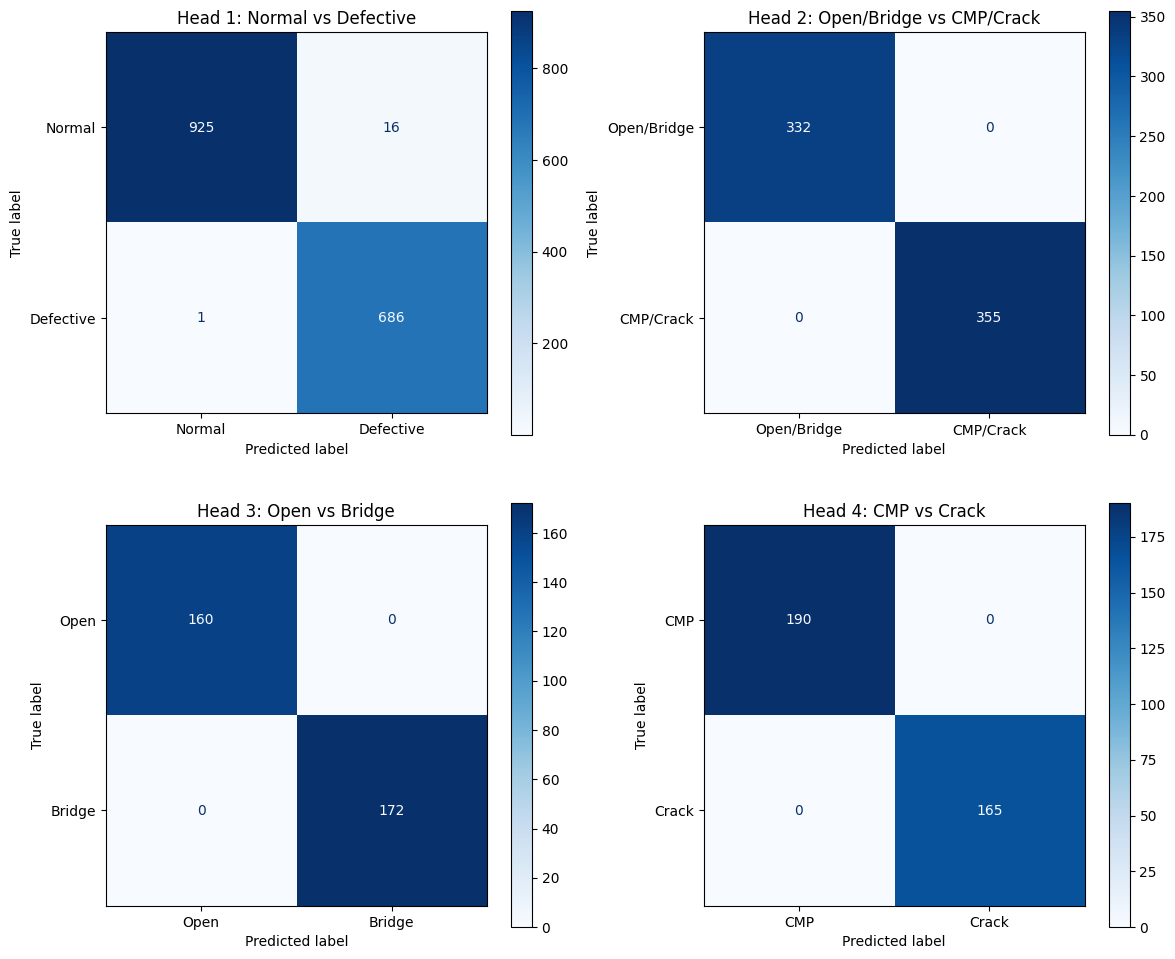

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_hierarchical_confusion_matrices(model, loader, device):
    model.eval()

    # Storage for predictions and actuals for all 4 heads
    all_preds = {h: [] for h in ['h1', 'h2', 'h3', 'h4']}
    all_targets = {h: [] for h in ['h1', 'h2', 'h3', 'h4']}

    head_names = {
        'h1': ['Normal', 'Defective'],
        'h2': ['Open/Bridge', 'CMP/Crack'],
        'h3': ['Open', 'Bridge'],
        'h4': ['CMP', 'Crack']
    }

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)

            for i, h in enumerate(['h1', 'h2', 'h3', 'h4']):
                # Only include images that have a valid label for this head (not -1)
                mask = labels[:, i] != -1
                if mask.any():
                    # Get predictions (argmax)
                    _, preds = torch.max(outputs[h][mask], 1)
                    all_preds[h].extend(preds.cpu().numpy())
                    all_targets[h].extend(labels[:, i][mask].cpu().numpy())

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, h in enumerate(['h1', 'h2', 'h3', 'h4']):
        if len(all_targets[h]) > 0:
            cm = confusion_matrix(all_targets[h], all_preds[h])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=head_names[h])
            disp.plot(ax=axes[i], cmap='Blues', values_format='d')
            axes[i].set_title(f"Head {i+1}: {head_names[h][0]} vs {head_names[h][1]}")
        else:
            axes[i].text(0.5, 0.5, f"No data for {h}", ha='center')

    plt.tight_layout()
    plt.show()

# EXECUTE EVALUATION
plot_hierarchical_confusion_matrices(model, train_loader, device)

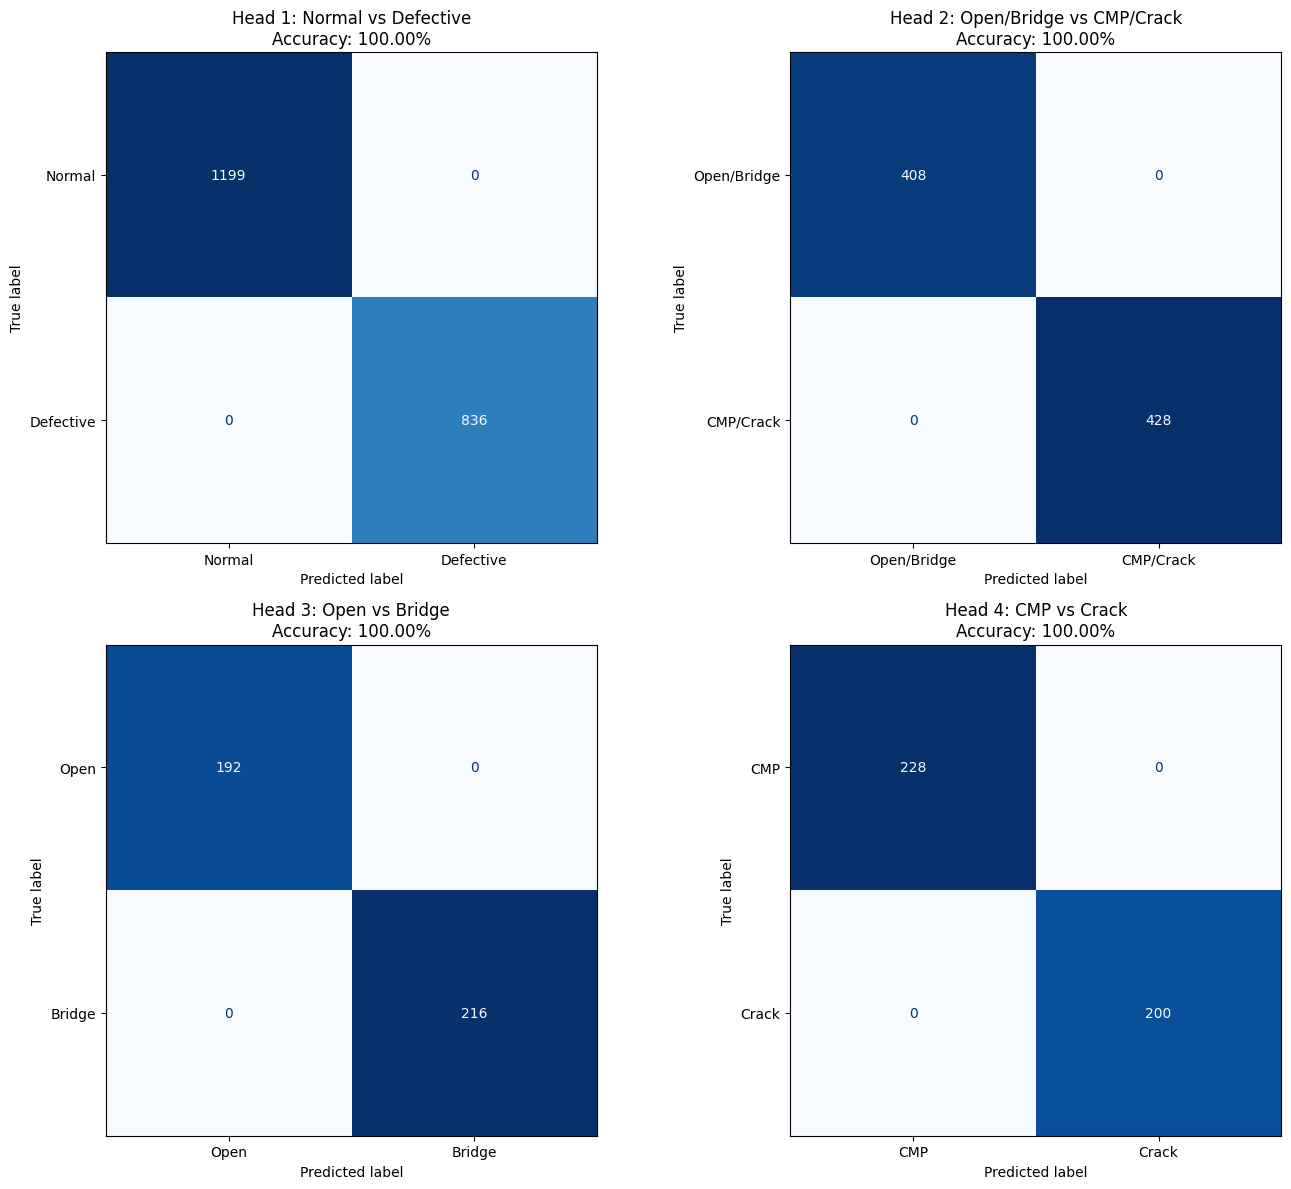

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_hierarchical_confusion_matrices(model, loader, device):
    model.eval()

    # Storage for predictions and actuals
    all_preds = {h: [] for h in ['h1', 'h2', 'h3', 'h4']}
    all_targets = {h: [] for h in ['h1', 'h2', 'h3', 'h4']}

    head_names = {
        'h1': ['Normal', 'Defective'],
        'h2': ['Open/Bridge', 'CMP/Crack'],
        'h3': ['Open', 'Bridge'],
        'h4': ['CMP', 'Crack']
    }

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)

            for i, h in enumerate(['h1', 'h2', 'h3', 'h4']):
                mask = labels[:, i] != -1
                if mask.any():
                    _, preds = torch.max(outputs[h][mask], 1)
                    all_preds[h].extend(preds.cpu().numpy())
                    all_targets[h].extend(labels[:, i][mask].cpu().numpy())

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()

    for i, h in enumerate(['h1', 'h2', 'h3', 'h4']):
        if len(all_targets[h]) > 0:
            # FIX: Added labels=[0, 1] to ensure a 2x2 matrix even if a class is missing
            cm = confusion_matrix(all_targets[h], all_preds[h], labels=[0, 1])

            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=head_names[h])
            disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

            # Calculate accuracy for this specific head
            acc = 100 * np.sum(np.diag(cm)) / np.sum(cm)
            axes[i].set_title(f"Head {i+1}: {head_names[h][0]} vs {head_names[h][1]}\nAccuracy: {acc:.2f}%")
        else:
            axes[i].text(0.5, 0.5, f"No samples found for\n{head_names[h][0]}/{head_names[h][1]}",
                         ha='center', va='center')

    plt.tight_layout()
    plt.show()

# EXECUTE EVALUATION
plot_hierarchical_confusion_matrices(model, train_loader, device)

In [24]:
import torch.quantization
from torch.quantization import get_default_qconfig, prepare, convert

def quantize_hierarchical_model(model, calibration_loader):
    # 1. Prepare for CPU-based Quantization (required for the conversion process)
    model.eval()
    model.to('cpu')

    # 2. Set the backend for ARM/Mobile (qnnpack)
    # This is optimized for the processors on your Cora Z7s and Zybo Z7 boards
    torch.backends.quantized.engine = 'qnnpack'
    model.qconfig = torch.quantization.get_default_qconfig('qnnpack')

    # 3. Fuse Modules (Simplified)
    # This merges Conv-Batchnorm-ReLU blocks to save cycles on the FPGA/ARM
    # We'll skip manual lists and use the built-in prepare utility
    model_prepared = prepare(model)

    # 4. Calibration: Use your SEM validation images to map the INT8 ranges
    # Since your images are monochrome (Mean: 0.3698), this step is critical
    print("Calibrating INT8 scales using validation data...")
    with torch.no_grad():
        for i, (images, _) in enumerate(calibration_loader):
            # Pass images on CPU to the prepared model
            model_prepared(images.to('cpu'))
            if i >= 15: break # ~250 images is plenty for stable scaling

    # 5. Convert to the final INT8 version
    model_int8 = convert(model_prepared)
    print("Quantization Successful!")
    return model_int8

# EXECUTE
quantized_model = quantize_hierarchical_model(model, val_loader)

Calibrating INT8 scales using validation data...


/tmp/ipython-input-454389911.py:17: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = prepare(model)
/tmp/ipython-input-454389911.py:29: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please mig

Quantization Successful!


In [26]:
import shutil

# Save locally
torch.save(model.state_dict(), 'sem_99_accuracy_fp32.pth')

# Backup to Drive
shutil.copy('sem_99_accuracy_fp32.pth', '/content/drive/MyDrive/sem_99_accuracy_fp32.pth')
print("Golden Weights backed up to Drive.")

Golden Weights backed up to Drive.


In [27]:
from collections import Counter

val_labels = [label.tolist() for _, label in val_subset]
# Check Head 1 distribution (Normal vs Defect)
h1_counts = Counter([l[0] for l in val_labels])
print(f"Validation Distribution (Head 1): {h1_counts}")

Validation Distribution (Head 1): Counter({0: 258, 1: 149})


In [28]:
from collections import Counter

val_labels = [label.tolist() for _, label in val_subset]
# Check Head 1 distribution (Normal vs Defect)
h1_counts = Counter([l[0] for l in val_labels])
print(f"Validation Distribution (Head 1): {h1_counts}")

Validation Distribution (Head 1): Counter({0: 258, 1: 149})


In [29]:
import torch.onnx

def export_fp32_to_onnx(model, output_path="sem_hierarchical_fp32.onnx"):
    # 1. Set to evaluation mode
    model.eval()

    # 2. Move model to CPU (Best practice for exporting to ONNX)
    model.to('cpu')

    # 3. Create a dummy input (Batch, Channel, Height, Width)
    # Since you resized images to 224x224, we use that here.
    dummy_input = torch.randn(1, 1, 224, 224)

    # 4. Define the naming for the branching heads
    input_names = ["input_sem_image"]
    output_names = ["h1_normal_defect", "h2_category", "h3_open_bridge", "h4_cmp_crack"]

    print(f"Exporting model to {output_path}...")

    torch.onnx.export(
        model,                  # Your trained model
        dummy_input,            # Sample input
        output_path,            # Filename
        export_params=True,     # Store the weights in the ONNX file
        opset_version=12,       # Standard opset for NXP eIQ and Zybo/Cora deployment
        do_constant_folding=True,
        input_names=input_names,
        output_names=output_names,
        dynamic_axes={          # Allows varying batch sizes during edge inference
            'input_sem_image': {0: 'batch_size'},
            'h1_normal_defect': {0: 'batch_size'},
            'h2_category': {0: 'batch_size'},
            'h3_open_bridge': {0: 'batch_size'},
            'h4_cmp_crack': {0: 'batch_size'}
        }
    )
    print("Export successful!")

# EXECUTE
export_fp32_to_onnx(model)

Exporting model to sem_hierarchical_fp32.onnx...


ModuleNotFoundError: No module named 'onnxscript'

In [30]:
!pip install onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 9.2 MB/s eta 0:00:00


In [31]:
import torch
import torch.onnx
import shutil

def export_fp32_to_onnx(model, output_path="sem_hierarchical_fp32.onnx"):
    # 1. Prepare model for export
    model.eval()
    model.to('cpu')

    # 2. Create a dummy input (1-channel, 224x224)
    # Matches your monochrome SEM image dimensions
    dummy_input = torch.randn(1, 1, 224, 224)

    # 3. Explicitly name inputs and hierarchical output heads
    input_names = ["sem_image_input"]
    output_names = [
        "h1_normal_defect",
        "h2_category_branch",
        "h3_open_bridge_leaf",
        "h4_cmp_crack_leaf"
    ]

    print(f"Exporting model to {output_path}...")

    # 4. Perform the export
    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        export_params=True,
        opset_version=15,       # Higher opset version for better layer support
        do_constant_folding=True,
        input_names=input_names,
        output_names=output_names,
        dynamic_axes={          # Supports variable batch sizes for edge deployment
            'sem_image_input': {0: 'batch_size'},
            'h1_normal_defect': {0: 'batch_size'},
            'h2_category_branch': {0: 'batch_size'},
            'h3_open_bridge_leaf': {0: 'batch_size'},
            'h4_cmp_crack_leaf': {0: 'batch_size'}
        }
    )

    # 5. Backup to Google Drive
    drive_path = f"/content/drive/MyDrive/{output_path}"
    shutil.copy(output_path, drive_path)
    print(f"Success! ONNX model exported and saved to Drive at: {drive_path}")

# EXECUTE
export_fp32_to_onnx(model)

Exporting model to sem_hierarchical_fp32.onnx...


/tmp/ipython-input-2451725452.py:26: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0208 06:10:43.106000 298 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 15 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
W0208 06:10:44.541000 298 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, alig

[torch.onnx] Obtain model graph for `SEMHierarchicalNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SEMHierarchicalNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 68 of general pattern rewrite rules.
Success! ONNX model exported and saved to Drive at: /content/drive/MyDrive/sem_hierarchical_fp32.onnx


In [32]:
!pip install onnxruntime

import onnxruntime as ort
import numpy as np

def verify_onnx_model(onnx_path, test_image):
    # 1. Start an inference session
    session = ort.InferenceSession(onnx_path)

    # 2. Prepare the input (match the name used in export)
    # Ensure test_image is [1, 1, 224, 224]
    input_name = session.get_inputs()[0].name

    # 3. Run Inference
    outputs = session.run(None, {input_name: test_image.numpy()})

    # 4. Display results for Head 1 (Normal vs Defect)
    h1_output = outputs[0]
    prediction = np.argmax(h1_output)
    print(f"ONNX Head 1 Prediction: {'Defect' if prediction == 1 else 'Normal'}")
    return outputs

# Test with one image from your val_loader
images, _ = next(iter(val_loader))
verify_onnx_model("sem_hierarchical_fp32.onnx", images[0:1])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 33.2 MB/s eta 0:00:00
ONNX Head 1 Prediction: Normal


[array([[ 2.4599793, -3.4880743]], dtype=float32),
 array([[-1.2949747,  0.5238666]], dtype=float32),
 array([[ 2.9060316, -2.4476438]], dtype=float32),
 array([[-1.95964  ,  2.0171528]], dtype=float32)]